In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0117.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0101.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0108.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0110.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0119.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0115.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0116.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0105.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0106.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0121.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0111.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0103.jpeg
/kaggle/input/covid19-image-dataset/C

In [47]:
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

np.random.seed(11)
tf.random.set_seed(11)
os.environ['PYTHONHASHSEED'] = str(11)

# Loading Data 

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

img_height, img_width = 224, 224
batch_size=64

#Create generator object for data
def generate_data(dir):
    datagen = ImageDataGenerator(rescale=1./255.) #Normalizing pixel values
    
    generator = datagen.flow_from_directory(
        dir,
        batch_size=batch_size,
        shuffle=True,
        seed=11,
        class_mode='binary',
        target_size=(img_height, img_width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

train_dir = '../input/covid19-image-dataset/Covid19-dataset/train'
test_dir = '../input/covid19-image-dataset/Covid19-dataset/test'

train_generator = generate_data(train_dir)
test_generator = generate_data(test_dir)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


In [49]:
#Class proportions
normal_prop = 90/(180 + 137)
pneu_prop = 90/(180 + 137)
covid_prop = 137/(180 + 137)

print(normal_prop, pneu_prop, covid_prop)

0.28391167192429023 0.28391167192429023 0.43217665615141954


There is a significantly higher proportion of COVID-19 cases in the training data.

# EDA

In [50]:
img_mats = train_generator[0][0][:20]
img_labels = train_generator[0][1][:20]

In [51]:
#Check img dimensions
img_mats[0].shape

(224, 224, 3)

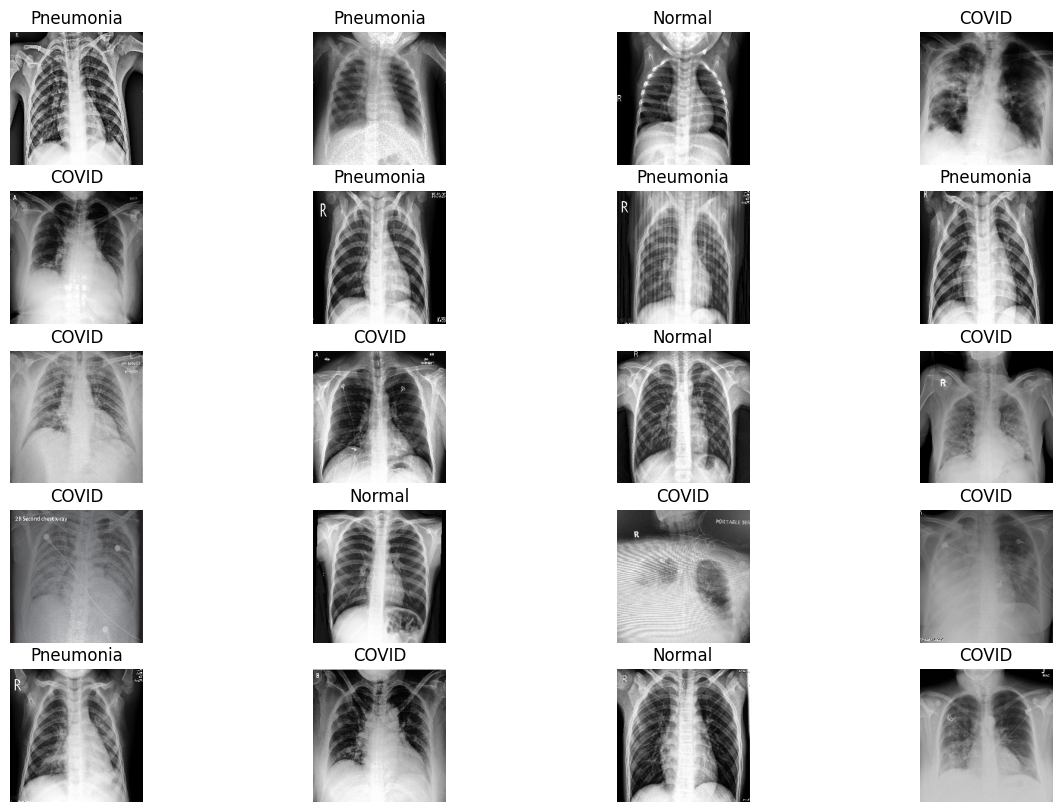

In [52]:
#Plotting 20 pictures from training data
plt.figure(figsize=(15, 10))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(img_mats[i])
    plt.title("Normal" if img_labels[i] == 0 else "Pneumonia" if img_labels[i] == 1 else "COVID")
    plt.axis("off")

A few notes:

1. Generally, x-rays corresponding to COVID appear quite "foggy," although one of the COVID images appears perfectly normal.
2. Pneumonia cases also appear "foggy", although to a much lesser extent.
3. Normal x-rays look, well, normal. Additionally, it also appears there is variation in chest size.

### Experimenting with image augmentation 

Found 251 images belonging to 3 classes.


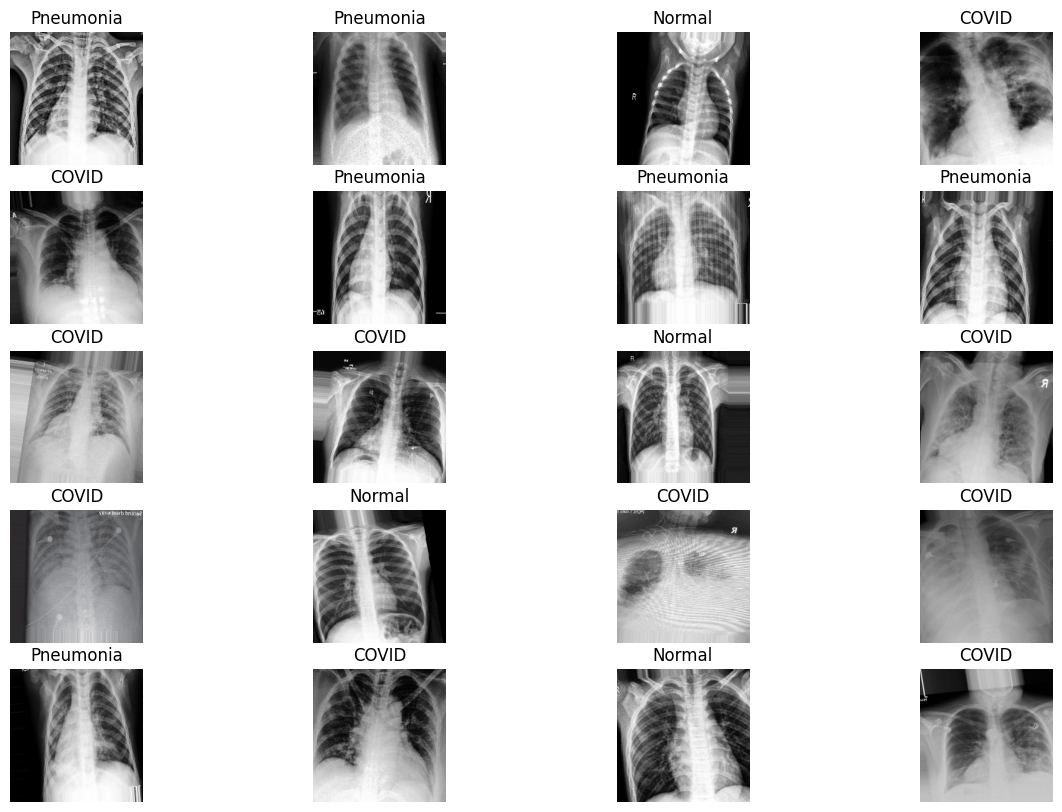

In [53]:
def augment_data(dir):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=0.2,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range = 0.2,
        horizontal_flip = True
    )
    generator = datagen.flow_from_directory(
        dir,
        batch_size=batch_size,
        seed=11,
        class_mode='binary',
        target_size=(img_height, img_width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

aug_train_generator = augment_data(train_dir)


aug_img_mats = aug_train_generator[0][0][:20]

plt.figure(figsize=(15, 10))
for i in range(20):
    ax = plt.subplot(int(np.ceil(20/4)),4, i + 1)
    plt.imshow(aug_img_mats[i])
    plt.title("Normal" if img_labels[i] == 0 else "Pneumonia" if img_labels[i] == 1 else "COVID")
    plt.axis("off")

# Model 

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [55]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'softmax', units = 3))

cnn.compile(optimizer = 'adam', loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])

In [56]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 64)       

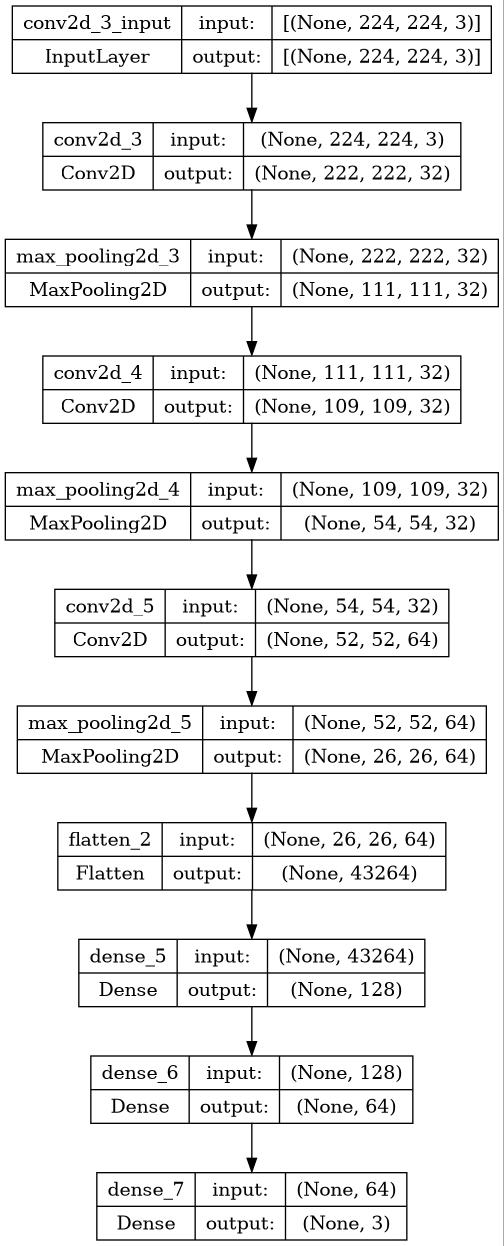

In [57]:
#Visualizing the model
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, to_file = 'DavidNet_tb.jpeg')

In [58]:
#Compute class weights to counteract class imbalance
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.labels), 
                               y = train_generator.labels)
cw = dict(zip(np.unique(train_generator.classes), weights))
print(cw)

{0: 1.1952380952380952, 1: 1.1952380952380952, 2: 0.7537537537537538}


In [59]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      restore_best_weights=True,
                      patience=3) #Stop training if loss does not decrease for 3 epochs and take the model with best loss

#Reduces learning rate by 30% if loss does not decrease in 2 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1,factor=0.3, min_lr=0.000001) 

callbacks_list = [early, learning_rate_reduction]

In [60]:
tf.random.set_seed(11)
cnn.fit(train_generator, epochs=25, validation_data=test_generator, 
        class_weight=cw, callbacks=callbacks_list, shuffle = True)

Epoch 1/25
4/4 [==============================] - 11s 2s/step - loss: 1.1375 - accuracy: 0.3944 - val_loss: 1.0403 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/25
4/4 [==============================] - 9s 2s/step - loss: 0.9445 - accuracy: 0.7729 - val_loss: 0.7926 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 3/25
4/4 [==============================] - 9s 2s/step - loss: 0.5176 - accuracy: 0.9044 - val_loss: 0.8231 - val_accuracy: 0.5152 - lr: 0.0010
Epoch 4/25
4/4 [==============================] - 9s 2s/step - loss: 0.4105 - accuracy: 0.8367 - val_loss: 0.6575 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/25
4/4 [==============================] - 9s 2s/step - loss: 0.3214 - accuracy: 0.8725 - val_loss: 0.4624 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 6/25
4/4 [==============================] - 9s 2s/step - loss: 0.1827 - accuracy: 0.9402 - val_loss: 0.3800 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 7/25
4/4 [==============================] - 9s 2s/step - loss: 0.1369 - accuracy: 0.9641 - va

# Measuring Model Performance 

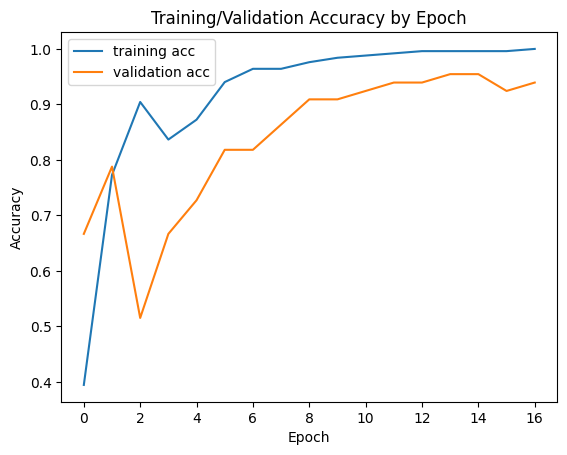

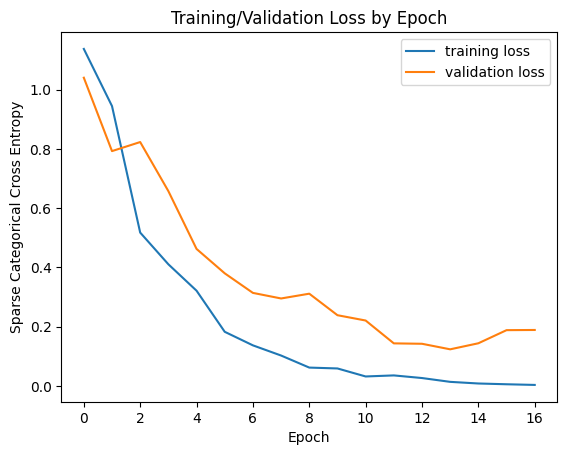

In [61]:
history = cnn.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.title('Training/Validation Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();
plt.figure();

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training/Validation Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Cross Entropy')
plt.legend()

2/2 [==============================] - 0s 209ms/step


[Text(45.72222222222221, 0.5, 'True_labels')]

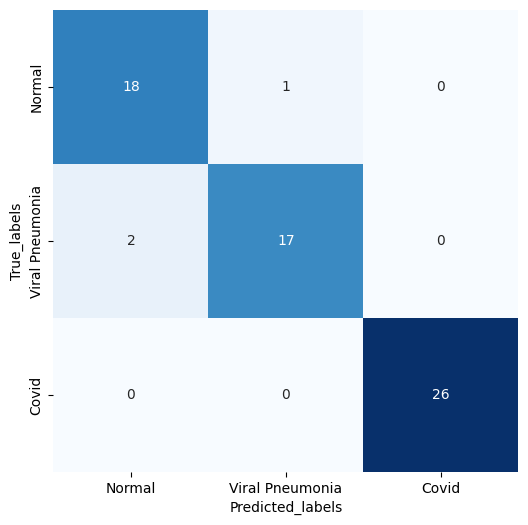

In [62]:
from sklearn.metrics import classification_report,confusion_matrix
ytest = np.array([])
xtest = []

for i in range(int(np.ceil(len(test_generator.classes))/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob = cnn.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Pneumonia','Covid'],yticklabels=['Normal','Viral Pneumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')

In [63]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92        19
         1.0       0.94      0.89      0.92        19
         2.0       1.00      1.00      1.00        26

    accuracy                           0.95        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.95      0.95      0.95        64



The CNN perfectly classifies the COVID-19 x-rays in the validation set.

### Misclassified Images 

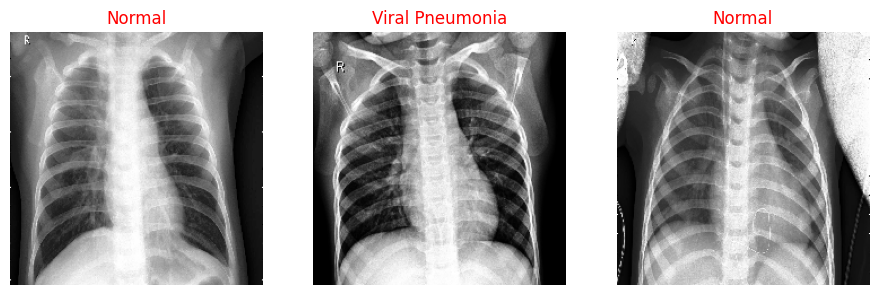

In [64]:
misclassified = np.where(ypred != ytest)[0]

plt.figure(figsize=(15, 10))
for i,n in enumerate(misclassified):
    ax = plt.subplot(int(np.ceil(len(misclassified)/4)),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid",color='r')
    plt.axis("off")

### Training with image augmentation 

In [65]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      restore_best_weights=True,
                      patience=3) #Stop training if loss does not decrease for 3 epochs and take the model with best loss

#Reduces learning rate by 30% if loss does not decrease in 2 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1,factor=0.3, min_lr=0.000001) 

callbacks_list = [early, learning_rate_reduction]

In [66]:
#Training with image augmentation
tf.random.set_seed(11)
cnn.fit(aug_train_generator,
        validation_data = test_generator,
        epochs=50, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
4/4 [==============================] - 13s 3s/step - loss: 0.9734 - accuracy: 0.7410 - val_loss: 0.3917 - val_accuracy: 0.8636 - lr: 3.0000e-04
Epoch 2/50
4/4 [==============================] - 11s 3s/step - loss: 0.7733 - accuracy: 0.7291 - val_loss: 0.2502 - val_accuracy: 0.8788 - lr: 3.0000e-04
Epoch 3/50
4/4 [==============================] - 11s 3s/step - loss: 0.6606 - accuracy: 0.7450 - val_loss: 0.2194 - val_accuracy: 0.9242 - lr: 3.0000e-04
Epoch 4/50
4/4 [==============================] - 11s 3s/step - loss: 0.6174 - accuracy: 0.7490 - val_loss: 0.3286 - val_accuracy: 0.8788 - lr: 3.0000e-04
Epoch 5/50
4/4 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.7928
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
4/4 [==============================] - 11s 3s/step - loss: 0.5289 - accuracy: 0.7928 - val_loss: 0.3544 - val_accuracy: 0.8788 - lr: 3.0000e-04
Epoch 6/50
4/4 [==============================] - 11s 3s/step - loss

6/6 [==============================] - 1s 198ms/step


[Text(45.72222222222221, 0.5, 'True_labels')]

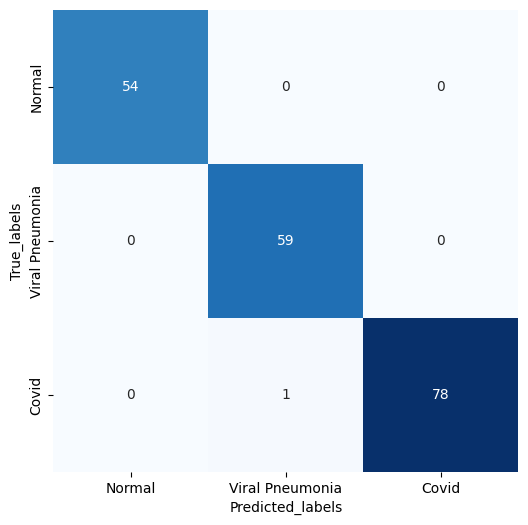

In [67]:
#Evaluate performance on training set after training with image augmentation
ytrain = np.array([])
xtrain = []

for i in range(int(np.ceil(len(train_generator.classes))/batch_size)):
    xtrain.append(train_generator[i][0]) 
    ytrain = np.concatenate((ytrain,train_generator[i][-1])) 
    
xtrain = np.concatenate((xtrain),axis=0)

ypred_prob = cnn.predict(xtrain)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Pneumonia','Covid'],yticklabels=['Normal','Viral Pneumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')

In [68]:
print(classification_report(ytrain, ypred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        54
         1.0       0.98      1.00      0.99        59
         2.0       1.00      0.99      0.99        79

    accuracy                           0.99       192
   macro avg       0.99      1.00      1.00       192
weighted avg       0.99      0.99      0.99       192



2/2 [==============================] - 0s 214ms/step


[Text(45.72222222222221, 0.5, 'True_labels')]

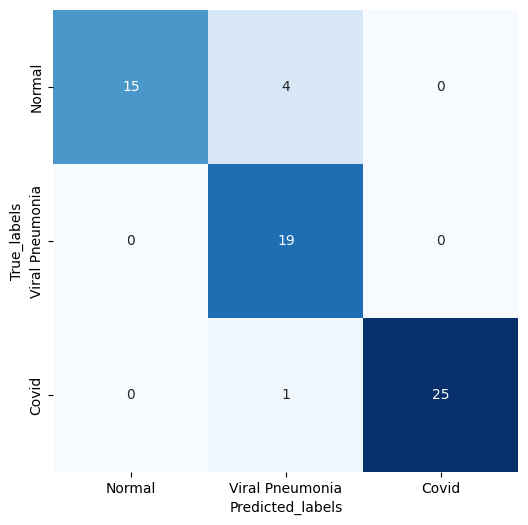

In [69]:
#Evaluate performance on test set after training with image augmentation
ytest = np.array([])
xtest = []

for i in range(int(np.ceil(len(test_generator.classes))/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest = np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob = cnn.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Pneumonia','Covid'],yticklabels=['Normal','Viral Pneumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')

In [70]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88        19
         1.0       0.79      1.00      0.88        19
         2.0       1.00      0.96      0.98        26

    accuracy                           0.92        64
   macro avg       0.93      0.92      0.92        64
weighted avg       0.94      0.92      0.92        64



### Examining Incorrect Classifications from custom CNN (after augmented image training)

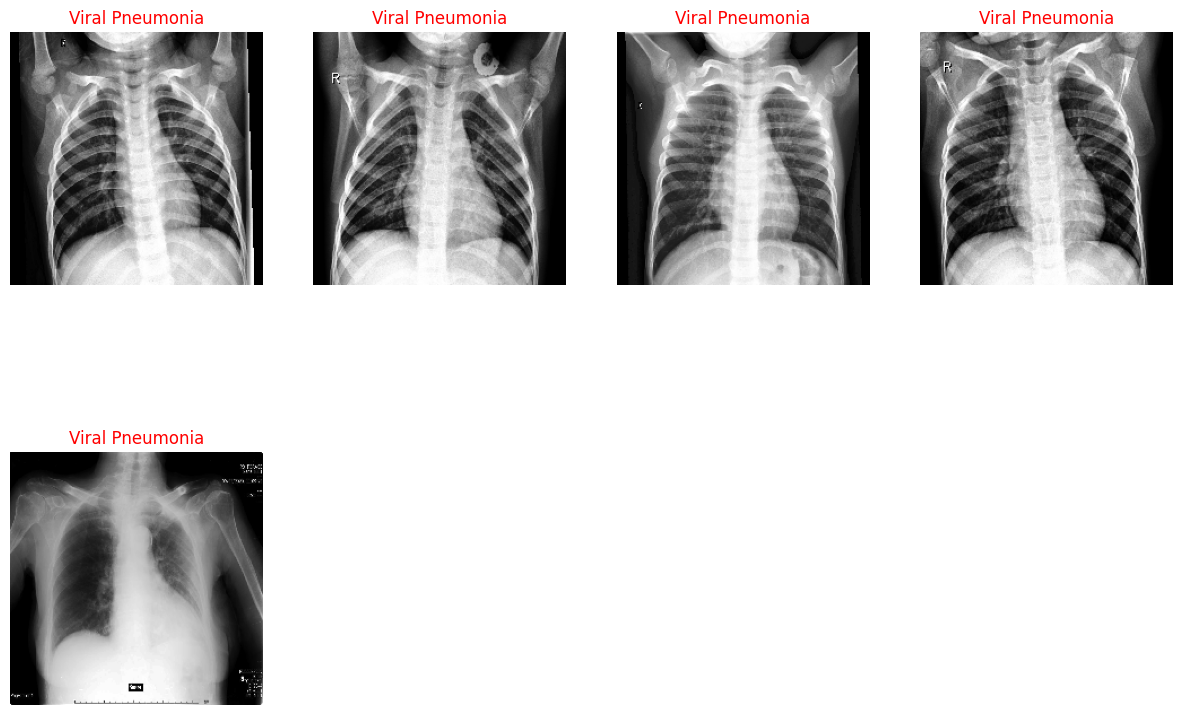

In [71]:
misclassified = np.where(ypred != ytest)[0]

plt.figure(figsize=(15, 10))
for i,n in enumerate(misclassified):
    ax = plt.subplot(int(np.ceil(len(misclassified)/4)),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid",color='r')
    plt.axis("off")

# Comparison Against DenseNet121 w/ CheXNet Weights

### DenseNet121 

In [72]:
densenet = tf.keras.applications.DenseNet121(
    weights = None, 
    include_top = False,
    input_shape = (img_width, img_height, 3),
    classes = 3
)

#densenet.summary()

In [73]:
#Loading CheXNet weights
chexnet_weights_path = "/kaggle/input/chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5"
predictions = Dense(14, activation='softmax', name='predictions')(densenet.output)
densenet = tf.keras.Model(inputs=densenet.input, outputs=predictions) 
densenet.load_weights(chexnet_weights_path)
print("CheXNet loaded")

CheXNet loaded


In [74]:
#Removing the last dense layer to modify it for 3 classes
new_model = tf.keras.Model(inputs=densenet.input, outputs=densenet.layers[-2].output)

# Display the summary of the new model
#new_model.summary()

In [75]:
#Freezing the weights in each layer, I only want to train the last layer I will add
for layer in new_model.layers:
    layer.trainable = False

I add a global pooling layer, and then construct the final fully connected NN with a flatten layer, and 2 dense layers.

In [76]:
#Adding global pooling, flatten, and 2 dense layers 
global_pool = tf.keras.layers.GlobalAveragePooling2D()(new_model.output)
flatten_layer = Flatten()(global_pool)
pre_class_layer = Dense(activation = 'relu', units = 64)(flatten_layer)
classification_layer = Dense(3, activation='softmax')(pre_class_layer)

densenet_3 = tf.keras.Model(inputs=new_model.input, outputs=classification_layer)

# Display the summary of the new model
densenet_3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [77]:
densenet_3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

### DenseNet Training 

In [78]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      restore_best_weights=True,
                      patience=3) #Stop training if loss does not decrease for 3 epochs and take the model with best loss

#Reduces learning rate by 30% if loss does not decrease in 2 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1,factor=0.3, min_lr=0.000001) 

callbacks_list = [early, learning_rate_reduction]

In [79]:
tf.random.set_seed(11)
densenet_3.fit(train_generator, epochs=25, validation_data=test_generator, 
        class_weight=cw, callbacks=callbacks_list, shuffle = True)

Epoch 1/25
4/4 [==============================] - 30s 6s/step - loss: 1.1681 - accuracy: 0.3028 - val_loss: 1.1112 - val_accuracy: 0.3182 - lr: 0.0010
Epoch 2/25
4/4 [==============================] - 22s 5s/step - loss: 1.0611 - accuracy: 0.3944 - val_loss: 1.0449 - val_accuracy: 0.3939 - lr: 0.0010
Epoch 3/25
4/4 [==============================] - 21s 5s/step - loss: 1.0375 - accuracy: 0.5498 - val_loss: 1.0458 - val_accuracy: 0.4848 - lr: 0.0010
Epoch 4/25
4/4 [==============================] - 22s 6s/step - loss: 0.9883 - accuracy: 0.6056 - val_loss: 1.0024 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 5/25
4/4 [==============================] - 21s 5s/step - loss: 0.9546 - accuracy: 0.7052 - val_loss: 0.9648 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 6/25
4/4 [==============================] - 22s 5s/step - loss: 0.9273 - accuracy: 0.7092 - val_loss: 0.9476 - val_accuracy: 0.6515 - lr: 0.0010
Epoch 7/25
4/4 [==============================] - 22s 6s/step - loss: 0.8842 - accuracy: 0.792

### Measuring Model Performance (DenseNet121)

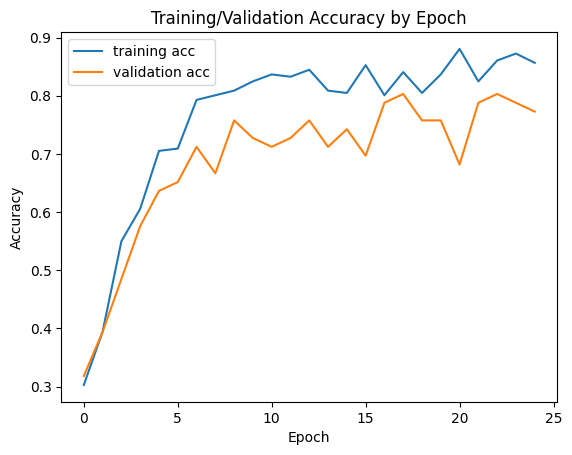

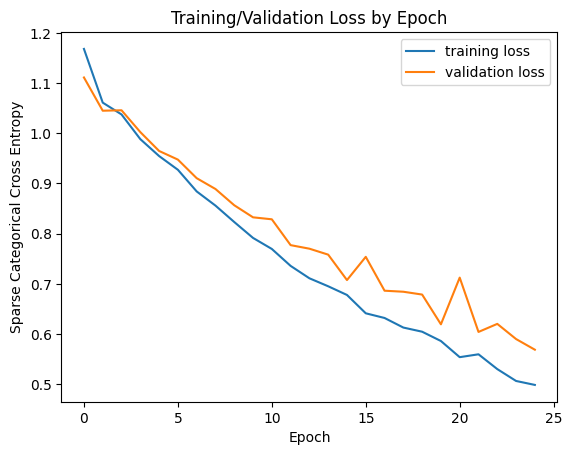

In [80]:
history = densenet_3.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.title('Training/Validation Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();
plt.figure();

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training/Validation Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Cross Entropy')
plt.legend()

The training and validation loss plot indicate that with even more training, the CheXNet model can achieve even lower validation loss. Due to computational/time restraints, I will not choose to train more than 25 epochs.

2/2 [==============================] - 6s 2s/step


[Text(45.72222222222221, 0.5, 'True_labels')]

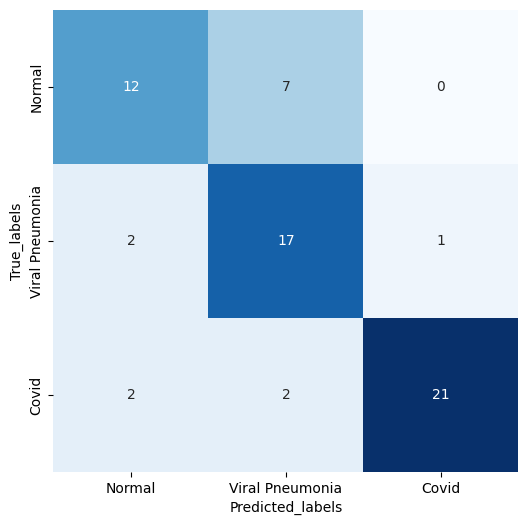

In [81]:
from sklearn.metrics import classification_report,confusion_matrix
ytest = np.array([])
xtest = []

for i in range(int(np.ceil(len(test_generator.classes))/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob = densenet_3.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Pneumonia','Covid'],yticklabels=['Normal','Viral Pneumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')

In [82]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.75      0.63      0.69        19
         1.0       0.65      0.85      0.74        20
         2.0       0.95      0.84      0.89        25

    accuracy                           0.78        64
   macro avg       0.79      0.77      0.77        64
weighted avg       0.80      0.78      0.78        64



### Misclassified Images from DenseNet121 

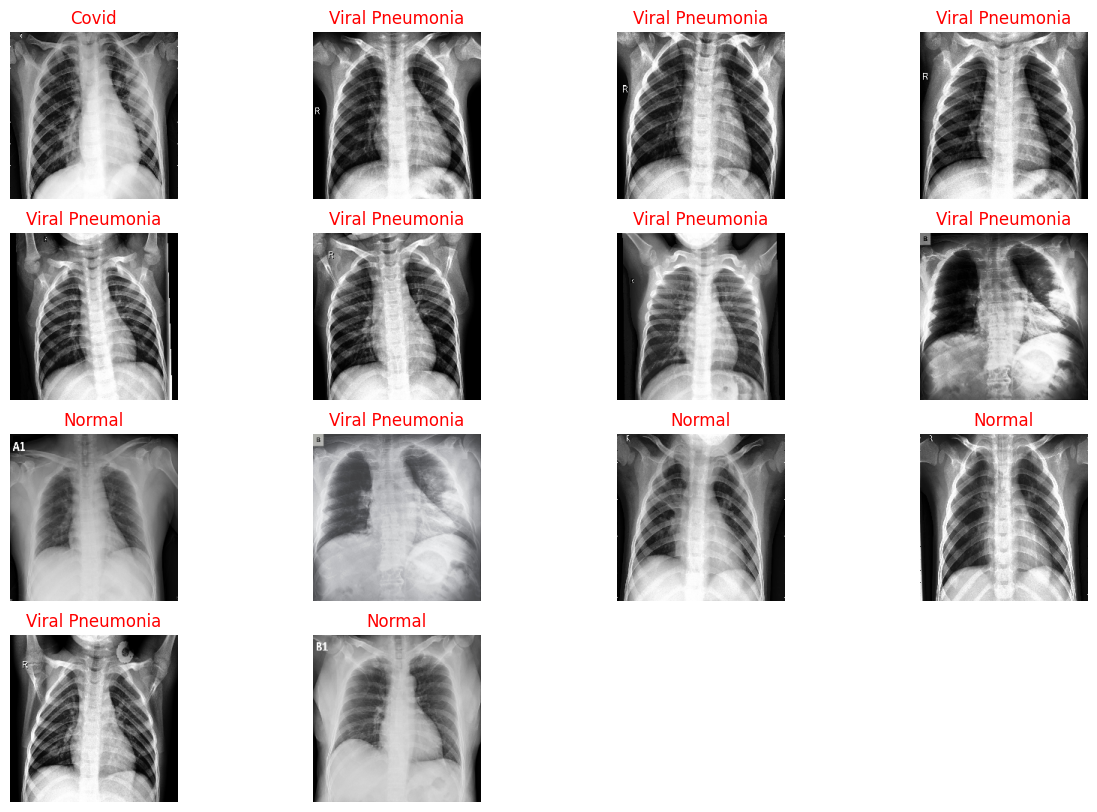

In [83]:
misclassified = np.where(ypred != ytest)[0]

plt.figure(figsize=(15, 10))
for i,n in enumerate(misclassified):
    ax = plt.subplot(int(np.ceil(len(misclassified)/4)),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid",color='r')
    plt.axis("off")

### Training DenseNet With Image Augmentation 

In [84]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      restore_best_weights=True,
                      patience=3) #Stop training if loss does not decrease for 3 epochs and take the model with best loss

#Reduces learning rate by 30% if loss does not decrease in 2 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1,factor=0.3, min_lr=0.000001) 

callbacks_list = [early, learning_rate_reduction]

In [85]:
#Training with image augmentation
tf.random.set_seed(11)
densenet_3.fit(aug_train_generator,
        validation_data = test_generator,
        epochs=50, 
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
4/4 [==============================] - 27s 6s/step - loss: 0.5851 - accuracy: 0.7928 - val_loss: 0.5576 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 23s 6s/step - loss: 0.5544 - accuracy: 0.8088 - val_loss: 0.5450 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 22s 6s/step - loss: 0.5363 - accuracy: 0.8446 - val_loss: 0.5292 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 23s 6s/step - loss: 0.5533 - accuracy: 0.8406 - val_loss: 0.5278 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 23s 6s/step - loss: 0.5528 - accuracy: 0.8048 - val_loss: 0.5119 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 22s 5s/step - loss: 0.5544 - accuracy: 0.7888 - val_loss: 0.5142 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 23s 6s/step - loss: 0.5133 - accuracy: 0.864

6/6 [==============================] - 11s 2s/step


[Text(45.72222222222221, 0.5, 'True_labels')]

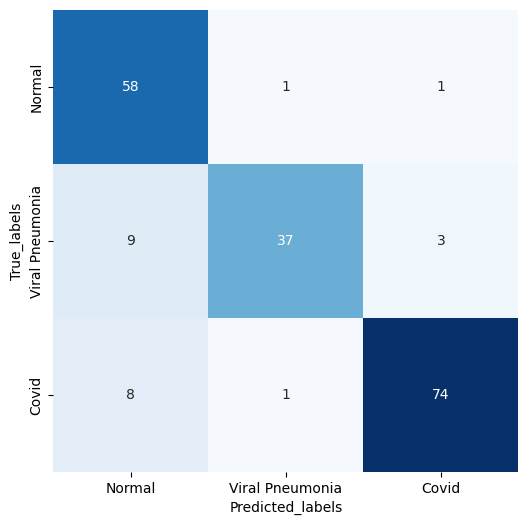

In [86]:
#Evaluate performance on training set after training with image augmentation
ytrain = np.array([])
xtrain = []

for i in range(int(np.ceil(len(train_generator.classes))/batch_size)):
    xtrain.append(train_generator[i][0]) 
    ytrain = np.concatenate((ytrain,train_generator[i][-1])) 
    
xtrain = np.concatenate((xtrain),axis=0)

ypred_prob = densenet_3.predict(xtrain)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Pneumonia','Covid'],yticklabels=['Normal','Viral Pneumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')

In [87]:
print(classification_report(ytrain, ypred))

              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86        60
         1.0       0.95      0.76      0.84        49
         2.0       0.95      0.89      0.92        83

    accuracy                           0.88       192
   macro avg       0.89      0.87      0.87       192
weighted avg       0.89      0.88      0.88       192



2/2 [==============================] - 4s 2s/step


[Text(45.72222222222221, 0.5, 'True_labels')]

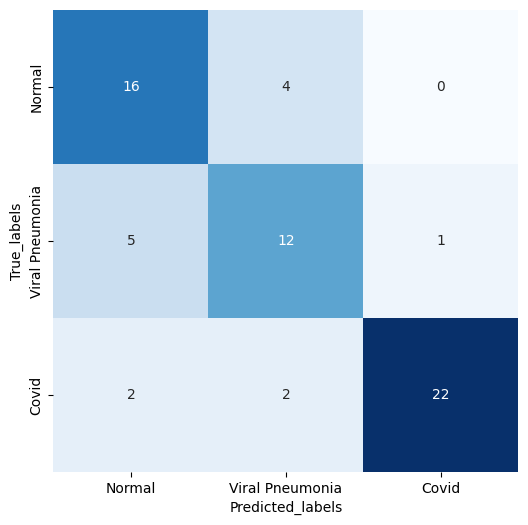

In [88]:
#Evaluate performance on test set after training with image augmentation
ytest = np.array([])
xtest = []

for i in range(int(np.ceil(len(test_generator.classes))/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest = np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob = densenet_3.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Pneumonia','Covid'],yticklabels=['Normal','Viral Pneumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')

In [89]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.74        20
         1.0       0.67      0.67      0.67        18
         2.0       0.96      0.85      0.90        26

    accuracy                           0.78        64
   macro avg       0.77      0.77      0.77        64
weighted avg       0.79      0.78      0.78        64



### Examining Incorrect Classifications from DenseNet (after image augmentation training)

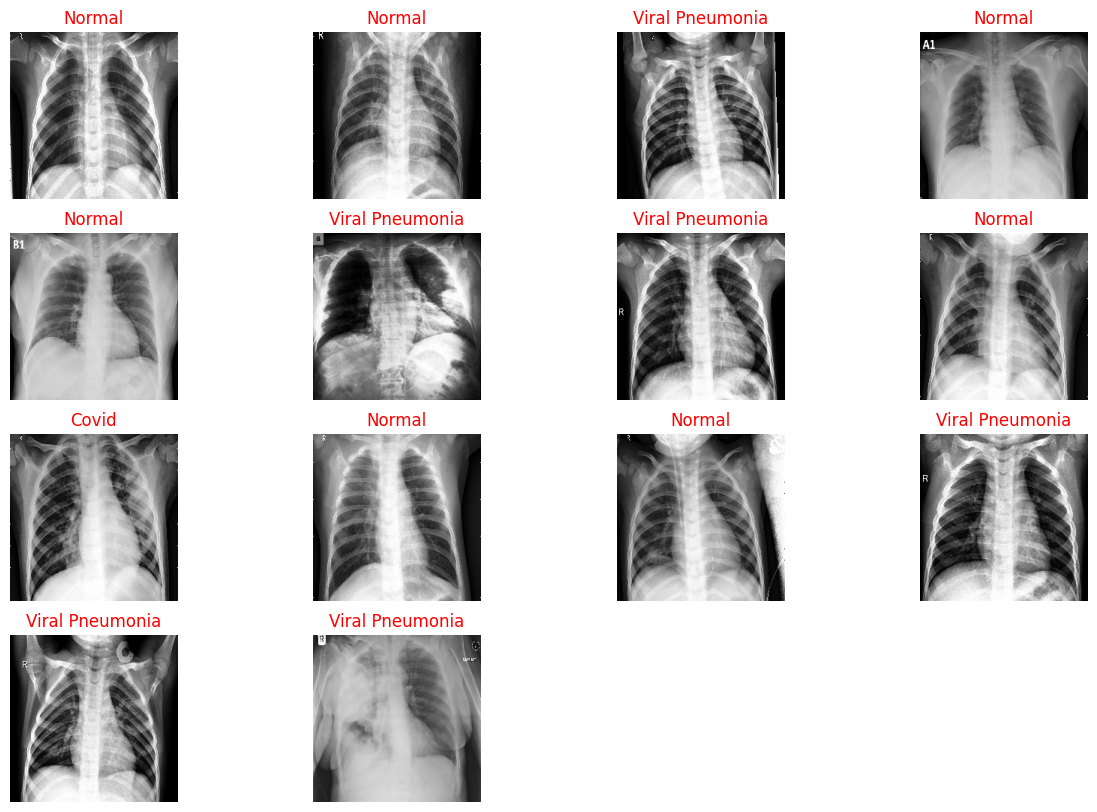

In [90]:
misclassified = np.where(ypred != ytest)[0]

plt.figure(figsize=(15, 10))
for i,n in enumerate(misclassified):
    ax = plt.subplot(int(np.ceil(len(misclassified)/4)),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid", color='r')
    plt.axis("off")